# SAM Controlnet Dataset creation


In [21]:
params = {
    "number_of_samples": 10,
    "generate_test": False,
}

# Install dependency (kaggle only)

In [22]:
import os

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', ''):  
    !pip install transformers==4.29.0
    !pip install accelerate==0.19.0

## Utility functions

Run the cells below to import the needed utility functions for displaying the masks!

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import gc

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks, random_color=True):
  plt.imshow(np.array(raw_image))
  masks = np.array(masks)
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=random_color)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

def show_all_masks(masks, random_color=True):
    masks = np.array(masks)
    ax = plt.gca()
    ax.set_autoscale_on(True)
    for mask in masks:
        show_mask(mask, ax=ax, random_color=random_color)
    plt.axis("off")
    plt.show()
    del mask
    gc.collect()

## Data Loading

In [24]:
from datasets import load_dataset

number_of_samples = params["number_of_samples"]

dataset = load_dataset("HuggingFaceM4/COCO", split=f'train[0:{number_of_samples}]')

# display the list of available features
dataset[0].keys()

No config specified, defaulting to: coco/2014
Found cached dataset coco (/Users/baptiste/.cache/huggingface/datasets/HuggingFaceM4___coco/2014/1.0.0/7dba4b1d9b12e588770263b87c2a1fd7b03072c0a0cf550c896dbd09bf2bb7f8)


dict_keys(['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences', 'cocoid'])

## Model loading

In [29]:
from transformers import pipeline
import torch

device = torch.device(0 if torch.cuda.is_available() else "cpu")

print(device)

generator = pipeline("mask-generation", model="facebook/sam-vit-base", device=device)

# Generate a masks (for testing)


<class 'PIL.JpegImagePlugin.JpegImageFile'>


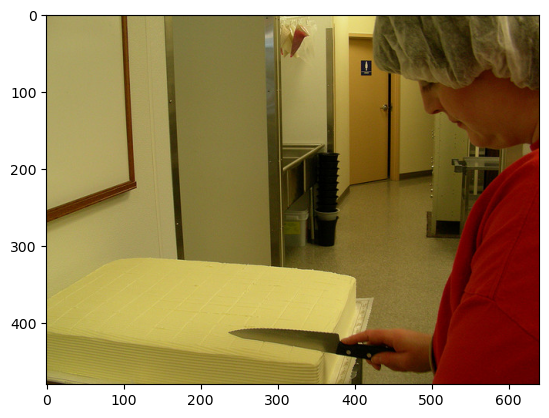

In [26]:
from PIL import Image
import requests

raw_image = dataset[0]["image"]

print(type(raw_image))

plt.imshow(raw_image)

In [27]:
%%time


if params["generate_test"]:
    outputs = generator(raw_image, points_per_batch=64)

    # 1m24 - 64
    # 2m11 - 16

    show_masks_on_image(raw_image, outputs["masks"])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


# Creating datasets

We use sam to create segmentation map from our coco dataset

In [28]:
# %%time

import time

# create a mask for each image and add it to the dataset using map
def create_mask(example):
    # start = time.time()
    outputs = generator(example["image"], points_per_batch=64)
    # end = time.time()
    # # print time in seconds with 2 decimals
    # print(f"Time: {end - start:.2f}s")

    return {"mask" : outputs["masks"]}


dataset = dataset.map(create_mask)

KeyboardInterrupt: 

In [ ]:
number_of_examples = 2

for i in range(number_of_examples):
    show_masks_on_image(dataset[i]["image"], dataset[i]["mask"])
    show_all_masks(dataset[i]["mask"])

KeyError: 'mask'

## save Dataset and push to huggingface

In [ ]:
from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
import datasets

ddict = datasets.DatasetDict({
    "train": dataset,
})

ddict.push_to_hub("baptistecolle/sam-controlnet")

Pushing split train to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:00<00:00, 21620.12it/s]


## load Dataset from huggingface

Found cached dataset parquet (/Users/baptiste/.cache/huggingface/datasets/baptistecolle___parquet/baptistecolle--sam-controlnet-4aa815e346a5ac0e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 470.64it/s]


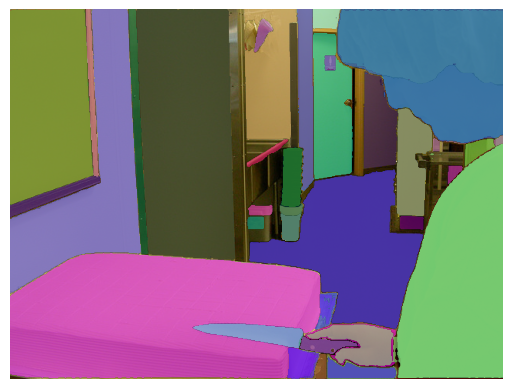

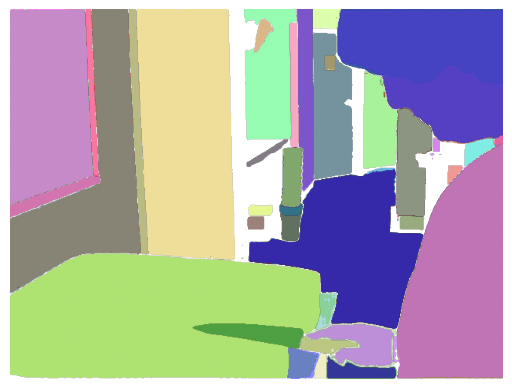

In [ ]:
saved_dataset = datasets.load_dataset("baptistecolle/sam-controlnet")

saved_dataset = saved_dataset["train"]

for i in range(number_of_examples):
    show_masks_on_image(saved_dataset[i]["image"], saved_dataset[i]["mask"])
    show_all_masks(saved_dataset[i]["mask"])